## Сверточные нейронные сети

Операция свертки (convolution):

![alt text](img/conv-01.gif "Title")

У свертки есть ядро (kernel) - матрица, веса которой ищутся в процессе обучения

![alt text](img/conv-02.gif "Title")

Свертки позволяют находить паттерны (*features*)

![alt text](img/conv-03.jpg "Title")

У свертки есть:
* Размер ядра (kernel_size)
* Размер шага (strides)
* Отступ (padding)

![alt text](img/conv-04.gif "Title")

Светочный слой нейросети [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) состоит из множества сверток (каждая со своим ядром и каждая нацелевается при обучении на свой паттерн)

![alt text](img/conv-05.jpg "Title")

На выходе сверточного слоя получаются карты признаков (*feature maps*). Это огромное количество информации, даже больше чем в исходном изображении.

Поэтому используется техника понижения размерности (*downsampling*) - **pooling**. Разновидности: MaxPooling и AveragePooling

![alt text](img/conv-06.jpg "Title")

Операции свертки и понижения размерности могут производится несколько раз, следуя друг за другом (*feature extraction*)

В конце, информацию необходимо "распрямить", получив обычный вектор (размерности 1хN). Сделать это можно операциями [GlobalAveragePooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) или [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

![alt text](img/conv-07.png "Title")

Такой вектор описывает найденные признаки и называется **embedding**

На финальном этапе, вектор признаков можно подать в качестве входа на стандартную нейросеть классификации (как в ирисах)

![alt text](img/conv-08.jpg "Title")

In [1]:
from PIL import Image
import numpy as np
import cv2

img = Image.open('/opt/datasets/MNIST/train/0/56940.png')
img2 = cv2.imread('/opt/datasets/MNIST/train/0/56940.png', cv2.IMREAD_GRAYSCALE)

In [2]:
#np.array(img)
img2.shape

(28, 28)

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #data_format = 'channels_first',
    #preprocessing_function = insightface_preprocess_input,
    #dtype = np.float64,
    validation_split = 0.05,
    #horizontal_flip = True,
    #rotation_range = 10,
    #zoom_range = [0.9, 1.1],
)

generator_args = {
    'target_size': (28, 28),
    'color_mode': 'grayscale',
    'class_mode': 'categorical',
    'batch_size': 32,
}

train_generator = datagen.flow_from_directory(directory = '/opt/datasets/MNIST/train', 'shuffle': True, **generator_args)
val_generator = datagen.flow_from_directory(directory = '/opt/datasets/MNIST/test', **generator_args)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [96]:
data = train_generator.next()
data[0].shape

(32, 28, 28, 1)

In [5]:
#train_generator.class_indices

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) 
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 10)                8

In [7]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),    # learning_rate = 1e-5
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
)

In [8]:
EPOCHS = 15

history = model.fit(
    x = train_generator,
    batch_size = 32,
    validation_data = val_generator,
    epochs = EPOCHS,
)

Epoch 1/15
1875/1875 [==============================] - 1832s 959ms/step - loss: 0.3990 - accuracy: 0.9288 - val_loss: 0.0916 - val_accuracy: 0.9727
Epoch 2/15
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0821 - accuracy: 0.9757 - val_loss: 0.0637 - val_accuracy: 0.9820
Epoch 3/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0640 - accuracy: 0.9808 - val_loss: 0.0748 - val_accuracy: 0.9782
Epoch 4/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0526 - accuracy: 0.9844 - val_loss: 0.0691 - val_accuracy: 0.9797
Epoch 5/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0488 - accuracy: 0.9853 - val_loss: 0.0525 - val_accuracy: 0.9826
Epoch 6/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0406 - accuracy: 0.9874 - val_loss: 0.0580 - val_accuracy: 0.9854
Epoch 7/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0377 - accuracy: 0.9888 - val_loss: 0.0550 - v

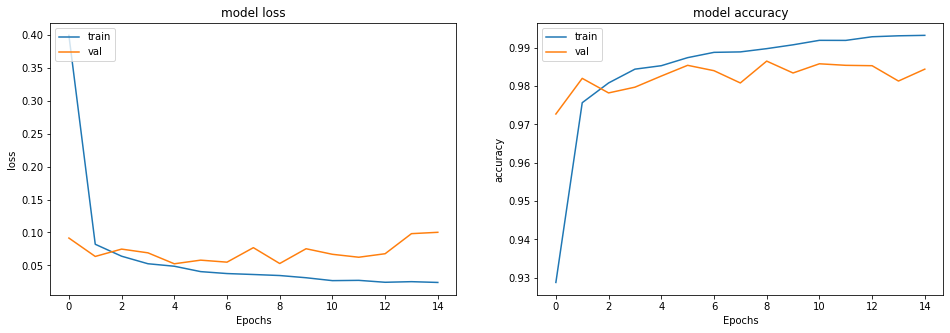

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(121)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('Epochs')
ax.legend(['train', 'val', 'runs'], loc='upper left')

ax = fig.add_subplot(122)
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epochs')
ax.legend(['train', 'val', 'runs'], loc='upper left')

In [40]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://www.nicepng.com/png/detail/939-9392093_handwritten-5.png')
img = Image.open(BytesIO(response.content))

In [41]:
np.array(img).shape

(586, 820, 3)

In [84]:
from PIL import Image, ImageOps

gimg = ImageOps.invert(img)
gimg = ImageOps.grayscale(gimg)
gimg = gimg.resize((28,28), Image.Resampling.LANCZOS)
gimg.show()
np.array(gimg).shape

(28, 28)

In [89]:
data = np.asarray(gimg)
data = data[np.newaxis, ...]
data.shape

(1, 28, 28)

In [88]:
pred = model.predict(data[..., np.newaxis])
np.argmax(pred)

3